### Kepler Objects of Interest

This dataset is a comprehensive list of all confirmed exoplanets, planetary candidates, and false positives determined on all the transits captured by Kepler. Utilizing the variables in this labeled dataset could make for a solid method of performing supervised learning from different variables in the dataset. See column “Disposition Using Kepler Data” for classification.  
Explanation of each column name is in [the dataset](datasets/KOI.csv)

In [292]:
import pandas as pd 
url = 'datasets/KOI.csv'
kepler_df = pd.read_csv(url, comment='#')
kepler_df.head(5)

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [293]:
kepler_df.shape

(9564, 49)

Let's inspect missing values first.

In [294]:
kepler_df.isnull().sum().sort_values(ascending=False)


koi_teq_err2         9564
koi_teq_err1         9564
kepler_name          6817
koi_score            1510
koi_steff_err2        483
koi_srad_err2         468
koi_srad_err1         468
koi_slogg_err2        468
koi_slogg_err1        468
koi_steff_err1        468
koi_depth_err2        454
koi_impact_err2       454
koi_depth_err1        454
koi_duration_err2     454
koi_duration_err1     454
koi_impact_err1       454
koi_time0bk_err2      454
koi_time0bk_err1      454
koi_period_err2       454
koi_period_err1       454
koi_impact            363
koi_prad_err1         363
koi_srad              363
koi_slogg             363
koi_teq               363
koi_prad_err2         363
koi_prad              363
koi_depth             363
koi_steff             363
koi_model_snr         363
koi_tce_plnt_num      346
koi_tce_delivname     346
koi_insol             321
koi_insol_err1        321
koi_insol_err2        321
koi_kepmag              1
kepoi_name              0
koi_duration            0
koi_time0bk 

Columns ending with err can be dropped - these represent the measurement uncertainties. 'kepoi_name' and 'kepler_name' can also be dropped, as they only provide the name and nothing else that might be significant to our model ('kepid' will be left for now). 'koi_tce_delivname' will also be dropped, as this is Kepler's pipeline metadata. 'koi_pdisposition' and 'koi_score' will be dropped, as they are related to the initial judgement of the same KOI and would therefore disrupt the prediction of our model.
'koi_teq' and 'koi_insol' are basically the same information in different units - let's drop 'koi_teq'. 'koi_time0bk' can be dropped, as the time reference of transit does not influence the fact if the object is a planet or not. 

In [295]:
kepler_clean_df = kepler_df.drop(kepler_df.filter(regex="(_err1|_err2)$").columns, axis=1)
subset = ['kepoi_name', 'kepler_name', 'koi_pdisposition', 'koi_score', 'koi_tce_delivname', 'koi_teq', 'koi_time0bk']
kepler_clean_df = kepler_clean_df.drop(subset, axis=1)
kepler_clean_df.isnull().sum().sort_values(ascending=False)

koi_prad            363
koi_depth           363
koi_srad            363
koi_slogg           363
koi_steff           363
koi_model_snr       363
koi_impact          363
koi_tce_plnt_num    346
koi_insol           321
koi_kepmag            1
koi_disposition       0
koi_duration          0
koi_period            0
koi_fpflag_ec         0
koi_fpflag_co         0
koi_fpflag_ss         0
koi_fpflag_nt         0
ra                    0
dec                   0
kepid                 0
dtype: int64

The maximum number of missing values per column is now less than 4%, but before dropping these rows, let's extract the rows where the assigned label is CANDIDATE - as we do not know whether that is a confirmed exoplanet or a false positive, this would confuse our model without any increase in accuracy.

In [296]:
candidates_df = kepler_clean_df[kepler_clean_df["koi_disposition"].str.strip().str.upper() == "CANDIDATE"].copy()

labeled_df = kepler_clean_df[kepler_clean_df["koi_disposition"].str.strip().str.upper().isin(["CONFIRMED","FALSE POSITIVE"])].copy()

labeled_df["label"] = (
    labeled_df["koi_disposition"]
    .str.strip().str.upper()
    .map({"CONFIRMED": 1, "FALSE POSITIVE": 0})
)

labeled_df.drop(["koi_disposition"], axis=1, inplace=True)
labeled_df.head(5)


,kepid,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_impact,koi_duration,koi_depth,koi_prad,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag,label
0,10797460,0,0,0,0,9.488036,0.146,2.95750,615.8,2.26,93.59,35.8,1.0,5455.0,4.467,0.927,291.93423,48.141651,15.347,1
1,10797460,0,0,0,0,54.418383,0.586,4.50700,874.8,2.83,9.11,25.8,2.0,5455.0,4.467,0.927,291.93423,48.141651,15.347,1
3,10848459,0,1,0,0,1.736952,1.276,2.40641,8079.2,33.46,891.96,505.6,1.0,5805.0,4.564,0.791,285.53461,48.285210,15.597,0
4,10854555,0,0,0,0,2.525592,0.701,1.65450,603.3,2.75,926.16,40.9,1.0,6031.0,4.438,1.046,288.75488,48.226200,15.509,1
5,10872983,0,0,0,0,11.094321,0.538,4.59450,1517.5,3.90,114.81,66.5,1.0,6046.0,4.486,0.972,296.28613,48.224670,15.714,1


Let's check for missing values now

In [297]:
labeled_df.isnull().sum().sort_values(ascending=False)

koi_tce_plnt_num    286
koi_srad            259
koi_impact          259
koi_slogg           259
koi_depth           259
koi_prad            259
koi_steff           259
koi_model_snr       259
koi_insol           219
koi_kepmag            1
dec                   0
ra                    0
kepid                 0
koi_fpflag_nt         0
koi_duration          0
koi_period            0
koi_fpflag_ec         0
koi_fpflag_co         0
koi_fpflag_ss         0
label                 0
dtype: int64

In [298]:
labeled_df.dropna(inplace=True, axis=0)
labeled_df.isnull().sum()

kepid               0
koi_fpflag_nt       0
koi_fpflag_ss       0
koi_fpflag_co       0
koi_fpflag_ec       0
koi_period          0
koi_impact          0
koi_duration        0
koi_depth           0
koi_prad            0
koi_insol           0
koi_model_snr       0
koi_tce_plnt_num    0
koi_steff           0
koi_slogg           0
koi_srad            0
ra                  0
dec                 0
koi_kepmag          0
label               0
dtype: int64

Any further feature engineering (logarithmizing, creating new features etc.) will happen at later stages, as a measure to obtain the best model across various metrics.

The set is pretty much ready for analysis - further processing will be performed before each individual model, depending on its nature. I will evaluate the following models:  
- Logistic Regression
- K Neighbors Classifier
- Support Vector Machine
- Random Forest
- Gradient Boosting
- Histogram-based Gradient Boosting Classification Tree

As for metrics, the common approach in available papers was to maximize recall and precision. We'll set a threshold precision (e.g. above 0.90) and try to maximize recall for this precision. The primary metric will be PR AUC (area under the curve of precision-recall)

## Logistic Regression
Let's start with Logistic Regression. This will require scaling the data. We'll also group by koi_id - which is why we'll use GroupShuffleSplit. We'll perform cross-validation and grid search. 

In [299]:
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

drop = ["label", "kepid"]
feat_cols = [c for c in labeled_df.columns if c not in drop]
cont = ["koi_period", "koi_impact", "koi_duration", "koi_depth", "koi_prad", "koi_insol", "koi_model_snr", 
        "koi_steff", "koi_slogg", "koi_srad", "ra", "dec", "koi_kepmag"]
flags = ["koi_fpflag_nt", "koi_fpflag_ss", "koi_fpflag_co", "koi_fpflag_ec", "koi_tce_plnt_num"]

X = labeled_df[feat_cols]
y = labeled_df["label"]
groups = labeled_df["kepid"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups.iloc[train_idx]

preprocess = ColumnTransformer([
    ("scale", StandardScaler(), cont),
    ("pass", "passthrough", flags)
])

pipeline = Pipeline([
    ("preprocessing", preprocess),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs"))
])

C_l2 = np.logspace(-3, 3, 7)                 # 1e-3 … 1e3
C_l1 = [1e-3, 1e-2, 1e-1, 1, 10, 100]        # smaller cap for L1/EN

param_grid = [
    {
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"],
        "clf__C": C_l2,
        "clf__class_weight": [None, "balanced"],
        "clf__max_iter": [3000],
        "clf__tol": [1e-4, 1e-3],
    },
    {
        "clf__penalty": ["l1"],
        "clf__solver": ["liblinear"],
        "clf__C": C_l1,
        "clf__class_weight": [None, "balanced"],
        "clf__max_iter": [5000],
        "clf__tol": [1e-3],   
    },
    {
        "clf__penalty": ["elasticnet"],
        "clf__solver": ["saga"],
        "clf__l1_ratio": [0.1, 0.5, 0.9],
        "clf__C": [0.1, 1, 10],
        "clf__class_weight": [None, "balanced"],
        "clf__max_iter": [5000],
        "clf__tol": [1e-3],
    },
]

kf = GroupKFold(n_splits=5)
log_reg_cv = GridSearchCV(pipeline, param_grid=param_grid, scoring="average_precision", cv=kf)
log_reg_cv.fit(X_train, y_train, groups=groups_train)

best_model = log_reg_cv.best_estimator_ # ready to use, best model
print("Best PR-AUC:", log_reg_cv.best_score_)
print("Best params:", log_reg_cv.best_params_)


Best PR-AUC: 0.9780081917069288
Best params: {'clf__C': 100, 'clf__class_weight': None, 'clf__max_iter': 5000, 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'clf__tol': 0.001}


Let's check our model

In [300]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       900
           1       0.91      0.96      0.94       518

    accuracy                           0.95      1418
   macro avg       0.95      0.95      0.95      1418
weighted avg       0.95      0.95      0.95      1418

[[852  48]
 [ 19 499]]


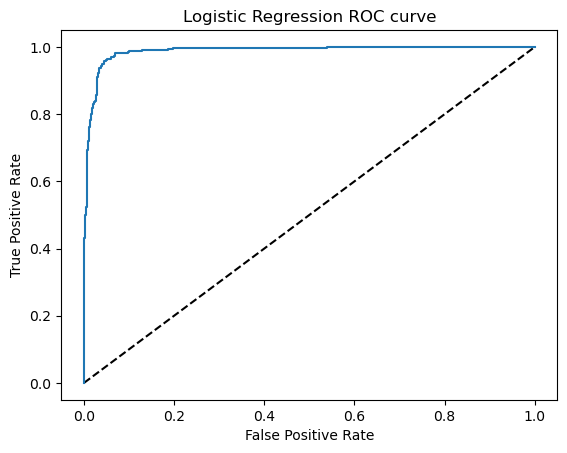

ROC-AUC score: 0.9874817674817675
Test PR-AUC (AP): 0.9768430564975589


In [301]:
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
y_pred_probabilities = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_probabilities)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC curve")
plt.show()
print("ROC-AUC score:", roc_auc_score(y_test, y_pred_probabilities))
print("Test PR-AUC (AP):", average_precision_score(y_test, y_pred_probabilities))

Let's try out different thresholds to find the highest recall for the precision>=0.90

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

thresholds = np.linspace(0.0, 1.0, 101)  
rows = []
for thr in thresholds:
    y_hat = (y_pred_probabilities >= thr).astype(int)
    p = precision_score(y_test, y_hat, zero_division=0)
    r = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    rows.append((thr, p, r, f1))

cand = [(thr, p, r, f1) for (thr, p, r, f1) in rows if p >= 0.90]
if cand:
    thr_star, p_star, r_star, f1 = max(cand, key=lambda x: x[2]) 
else:
    thr_star, p_star, r_star, f1 = 0.5, None, None 

print(f"Chosen threshold: {thr_star:.3f}  (Precision≥0.90)")
y_pred_thr = (y_pred_probabilities >= thr_star).astype(int)
print("Precision/Recall/F1 @ thr:", 
      precision_score(y_test, y_pred_thr), 
      recall_score(y_test, y_pred_thr),
      f1_score(y_test, y_pred_thr))
print(confusion_matrix(y_test, y_pred_thr))

Chosen threshold: 0.380  (Precision≥0.90)
Precision/Recall/F1 @ thr: 0.9014336917562724 0.971042471042471 0.9349442379182156
[[845  55]
 [ 15 503]]
0.9768430564975589


### Conclusion  
The highest recall when precision is above 0.90 (0.901) is 0.971. The PR-AUC is 0.977. This means that the model is very good and reliable. Potential improvements include further data preprocessing (feature engineering, logarithmizing etc.)